In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega
import seaborn as sns
# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [3]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [4]:
from sqlalchemy import create_engine
con= create_engine('postgresql://eicu@localhost:5432/eicu')

In [5]:
def round_up(x, base=5):
    return base * round(x/base)

### count the number of unique patients in the icu

In [5]:
query = query_schema + """
select  *
from patient
"""
df_total = pd.read_sql_query(query, con)

n_patient_icu = df_total['patientunitstayid'].nunique()
print("There are {} patients in the icu record.".format(n_patient_icu))


There are 200859 patients in the icu record.


### count the number of times that each patient into the ICU 

In [5]:
query = query_schema + """
with frequency_count as (
select  uniquepid as uniquep, count(*) as frequency
from patient
group by uniquep
)
select 
    CASE 
        when frequency > 4 then 'Greater than 4'
        else cast(frequency as TEXT)
    END as frequency_category,  count(*) as occurrence
from     frequency_count
group by frequency_category
order by occurrence DESC
"""
df_unique = pd.read_sql_query(query, con)
# df_unique['patientunitstayid'].nunique()

df_unique['data occurrence'] = df_unique['occurrence'] / df_total['uniquepid'].nunique() * 100.0
df_unique.sort_values('data occurrence', ascending=False, inplace=True)
df_unique.head()

,frequency_category,occurrence,data occurrence
0,1,100884,72.387294
1,2,26554,19.053291
2,3,6612,4.744308
3,4,2899,2.080119
4,Greater than 4,2418,1.734987


### select patients that the unitadmitsource comes from  emergency and direct department

In [6]:
query = query_schema + """

SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
 """

df_selected_patients = pd.read_sql_query(query, con)
# df_selected_patients.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients.csv', index=False)
# print("Data exported successfully to 'selected_patients.csv'.")
df_selected_patients.head()

,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
1,141178,Female,52,,Emergency Department,54.4,54.4,Step-Down Unit (SDU),Alive
2,141197,Male,71,"Sepsis, pulmonary",Emergency Department,102.1,102.1,Step-Down Unit (SDU),Alive
3,141208,Female,25,"Overdose, sedatives, hypnotics, antipsychotics...",Emergency Department,95.3,95.3,Home,Alive
4,141229,Female,> 89,"CHF, congestive heart failure",Emergency Department,89.8,86.6,Floor,Alive


In [7]:
n_selected_patients=df_selected_patients['patientunitstayid'].nunique()
print("There are {} unique patientunitstayid in the selected patients with the selected unitadmitsource: emergency and direct.".format(n_selected_patients))

There are 102266 unique patientunitstayid in the selected patients with the selected unitadmitsource: emergency and direct.


# Availability of statistical data

In [3]:
df_selected_patients = pd.read_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients.csv')

##  Admission Drug Table

In [8]:
query = query_schema + """
select *
from admissiondrug
order by drugoffset
"""

df_addrug = pd.read_sql_query(query, con)
n_drug = df_addrug['patientunitstayid'].nunique()
print("There are {} patients in the admission drug record.".format(n_drug))

There are 40740 patients in the admission drug record.


In [28]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select  adrug.admissiondrugid ,adrug.drugname, adrug.drugdosage, adrug.drugunit, adrug.drugadmitfrequency, sp.*
from admissiondrug adrug
join selected_patients sp
  on adrug.patientunitstayid = sp.patientunitstayid
 """

df_addrug_selected = pd.read_sql_query(query, con)

In [29]:
df_addrug_selected.head(n=10)

,admissiondrugid,drugname,drugdosage,drugunit,drugadmitfrequency,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,1589228,ELIQUIS ...,0.0,,,242954,Male,84,"Hemorrhage/hematoma, intracranial",Direct Admit,106.3,106.8,Floor,Alive
1,2063596,VICTOZA 2-PAK ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
2,2063592,METFORMIN HCL ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
3,2063589,LIPITOR ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
4,2063595,POTASSIUM CHLORIDE ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
5,2063591,FLECAINIDE ACETATE ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
6,2063588,ASPIRIN ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
7,2063594,OMEPRAZOLE ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
8,2063590,CITALOPRAM HBR ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive
9,2063593,NAPROXEN ...,0.0,,,243285,Male,67,Diabetic ketoacidosis,Emergency Department,96.7,98.8,Floor,Alive


In [12]:
# df_addrug_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_admissionDrug.csv')

In [14]:

n_drug_selected= len(df_addrug_selected['drugname'])
print("There are {} selected patients in the admission drug table with total {} records.".format(df_addrug_selected['patientunitstayid'].nunique(),n_drug_selected))

There are 23518 selected patients in the admission drug table with total 490189 records.


In [22]:
df_addrug_selected = pd.read_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_admissionDrug.csv')

In [23]:
df_addrug_selected = df_addrug_selected.set_index(['patientunitstayid', 'admissiondrugid'])
df_addrug_selected.sort_index(level = ['patientunitstayid', 'admissiondrugid'], inplace = True)
df_addrug_selected = df_addrug_selected[['drugname', 'drugdosage', 'drugunit','drugadmitfrequency', 'gender','age','apacheadmissiondx','unitadmitsource','admissionweight',	'dischargeweight','unitdischargelocation',	'unitdischargestatus']]
# Resample every 5 mins
# df_addrug_selected.rename(round_up, level = 'admissiondrugid', inplace = True)
df_addrug_selected['drugname'] = df_addrug_selected['drugname'].str.split(' ').str[0].str.lower()


In [26]:
df_addrug_selected.head(n=10)

drugname  drugdosage drugunit  \
patientunitstayid admissiondrugid                                    
242954            1589228             eliquis         0.0            
243285            2063588             aspirin         0.0            
                  2063589             lipitor         0.0            
                  2063590          citalopram         0.0            
                  2063591          flecainide         0.0            
                  2063592           metformin         0.0            
                  2063593            naproxen         0.0            
                  2063594          omeprazole         0.0            
                  2063595           potassium         0.0            
                  2063596             victoza         0.0            

                                  drugadmitfrequency gender age  \
patientunitstayid admissiondrugid                                 
242954            1589228                              Male  84   
243285            2063588                              Male  67   
                  2063589                              Male  67   
                  2063590                              Male  67   
                  2063591                              Male  67   
                  2063592                              Male  67   
                  2063593                              Male  67   
                  2063594                              Male  67   
                  2063595                              Male  67   
                  2063596                              Male  67   

                                                   apacheadmissiondx  \
patientunitstayid admissiondrugid                                      
242954            1589228          Hemorrhage/hematoma, intracranial   
243285            2063588                      Diabetic ketoacidosis   
                  2063589                      Diabetic ketoacidosis   
                  2063590                      Diabetic ketoacidosis   
                  2063591                      Diabetic ketoacidosis   
                  2063592                      Diabetic ketoacidosis   
                  2063593                      Diabetic ketoacidosis   
                  2063594                      Diabetic ketoacidosis   
                  2063595                      Diabetic ketoacidosis   
                  2063596                      Diabetic ketoacidosis   

                                        unitadmitsource  admissionweight  \
patientunitstayid admissiondrugid                                          
242954            1589228                  Direct Admit            106.3   
243285            2063588          Emergency Department             96.7   
                  2063589          Emergency Department             96.7   
                  2063590          Emergency Department             96.7   
                  2063591          Emergency Department             96.7   
                  2063592          Emergency Department             96.7   
                  2063593          Emergency Department             96.7   
                  2063594          Emergency Department             96.7   
                  2063595          Emergency Department             96.7   
                  2063596          Emergency Department             96.7   

                                   dischargeweight unitdischargelocation  \
patientunitstayid admissiondrugid                                          
242954            1589228                    106.8                 Floor   
243285            2063588                     98.8                 Floor   
                  2063589                     98.8                 Floor   
                  2063590                     98.8                 Floor   
                  2063591                     98.8                 Floor   
                  2063592                     98.8                 Floor   
     

In [30]:
freq_addrug = pd.DataFrame()
freq_addrug['noAnnotations'] = df_addrug_selected['drugname'].value_counts() 
freq_addrug['%'] = df_addrug_selected['drugname'].value_counts() / len(df_addrug_selected.index) * 100

freq_addrug

,noAnnotations,%
drugname,,
ASPIRIN,15568,3.175918
LISINOPRIL,10563,2.154883
LASIX,8437,1.721173
ALBUTEROL,6686,1.363964
OMEPRAZOLE,6677,1.362128
...,...,...
FERRIC CITRATE,1,0.000204
BOOST PLUS,1,0.000204
TASIGNA,1,0.000204


##  Admission Dx Table

In [64]:
query = query_schema + """
select *
from admissiondx
"""

df_addx = pd.read_sql_query(query, con)
n_dx = df_addx['patientunitstayid'].nunique()
print("There are {} icu patients in the admission diagnosis record.".format(n_dx))

There are 177863 icu patients in the admission diagnosis record.


In [69]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select addx.admissiondxid, addx.admitdxpath	,addx.admitdxname, addx.admitdxtext,sp.*
from admissiondx addx
join selected_patients sp
  on addx.patientunitstayid = sp.patientunitstayid
 """

df_addx_selected = pd.read_sql_query(query, con)

In [71]:
df_addx_selected.head()

,admissiondxid,admitdxpath,admitdxname,admitdxtext,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,718484,admission diagnosis|All Diagnosis|Non-operativ...,"Leukemia, acute myelocytic","Leukemia, acute myelocytic",142153,Male,74,"Leukemia, acute myelocytic",Direct Admit,71.1,79.1,Step-Down Unit (SDU),Alive
1,718483,admission diagnosis|Non-operative Organ System...,Hematology,Hematology,142153,Male,74,"Leukemia, acute myelocytic",Direct Admit,71.1,79.1,Step-Down Unit (SDU),Alive
2,718482,admission diagnosis|Was the patient admitted f...,No,No,142153,Male,74,"Leukemia, acute myelocytic",Direct Admit,71.1,79.1,Step-Down Unit (SDU),Alive
3,661834,admission diagnosis|Was the patient admitted f...,No,No,142248,Male,49,"Hematoma, subdural",Emergency Department,73.6,73.5,Other ICU,Alive
4,661835,admission diagnosis|Non-operative Organ System...,Neurologic,Neurologic,142248,Male,49,"Hematoma, subdural",Emergency Department,73.6,73.5,Other ICU,Alive


In [ ]:
# df_addx_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_admissionDx.csv')

In [75]:
n_dx_selected= len(df_addx_selected['admissiondxid'])
print("There are {} selected patients in the admission drug table with total {} records.".format(df_addx_selected['patientunitstayid'].nunique(),n_dx_selected))

There are 99534 selected patients in the admission drug table with total 327165 records.


In [10]:
df_addx_selected = pd.read_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_admissionDx.csv')

In [11]:
#  data to be grouped by patients (patientunitstayid) and their specific diagnosis IDs (admissiondxid),
df_addx_selected  = df_addx_selected .set_index(['patientunitstayid', 'admissiondxid'])
df_addx_selected .sort_index(level = ['patientunitstayid', 'admissiondxid'], inplace = True)
df_addx_selected  = df_addx_selected [['admitdxpath', 'admitdxname', 'admitdxtext','gender','age','apacheadmissiondx','unitadmitsource','admissionweight',	'dischargeweight','unitdischargelocation',	'unitdischargestatus']]
# Resample every 5 mins
# df_addrug_selected.rename(round_up, level = 'admissiondrugid', inplace = True)
df_addx_selected['admitdxpath'] = df_addx_selected['admitdxpath'].str.replace('|', '/')

In [12]:
df_addx_selected.head(n=10)

admitdxpath  \
patientunitstayid admissiondxid                                                      
141168            467412         admission diagnosis/Was the patient admitted f...   
                  467413         admission diagnosis/Non-operative Organ System...   
                  467414         admission diagnosis/All Diagnosis/Non-operativ...   
141197            612768         admission diagnosis/Was the patient admitted f...   
                  612769         admission diagnosis/Non-operative Organ System...   
                  612770         admission diagnosis/All Diagnosis/Non-operativ...   
141208            676591         admission diagnosis/Was the patient admitted f...   
                  676592         admission diagnosis/Non-operative Organ System...   
                  676593         admission diagnosis/All Diagnosis/Non-operativ...   
141229            689484         admission diagnosis/Was the patient admitted f...   

                                                                       admitdxname  \
patientunitstayid admissiondxid                                                      
141168            467412                                                        No   
                  467413                                            Cardiovascular   
                  467414             Rhythm disturbance (atrial, supraventricular)   
141197            612768                                                        No   
                  612769                                            Cardiovascular   
                  612770                                         Sepsis, pulmonary   
141208            676591                                                        No   
                  676592                                                Neurologic   
                  676593         Overdose, sedatives, hypnotics, antipsychotics...   
141229            689484                                                        No   

                                                                       admitdxtext  \
patientunitstayid admissiondxid                                                      
141168            467412                                                        No   
                  467413                                            Cardiovascular   
                  467414             Rhythm disturbance (atrial, supraventricular)   
141197            612768                                                        No   
                  612769                                            Cardiovascular   
                  612770                                         Sepsis, pulmonary   
141208            676591                                                        No   
                  676592                                                Neurologic   
                  676593         Overdose, sedatives, hypnotics, antipsychotics...   
141229            689484                                                        No   

                                 gender   age  \
patientunitstayid admissiondxid                 
141168            467412         Female    70   
                  467413         Female    70   
                  467414         Female    70   
141197            612768           Male    71   
                  612769           Male    71   
                  612770           Male    71   
141208            676591         Female    25   
                  676592         Female    25   
                  676593         Female    25   
141229            689484         Female  > 89   

                                                                 apacheadmissiondx  \
patientunitstayid admissiondxid                                                      
141168            467412             Rhythm disturbance (atrial, supraventricular)   
                  467413             Rhythm disturbance (atrial, supraventricular)   
                  467414             Rh

In [22]:
from bigtree import Node, list_to_tree, tree_to_dot, dataframe_to_tree, tree_to_pillow

paths_mult_ = df_addx_selected.groupby('admitdxpath', dropna = True)['admitdxpath'].size().to_frame('noAnnotations')
paths_mult_.reset_index(inplace=True)
paths_mult_.sort_values('noAnnotations', ascending = False, inplace = True)

paths_ = list(pd.unique(df_addx_selected['admitdxpath']))
root_ = dataframe_to_tree(paths_mult_, sep = '/')
root_.show(attr_list=["noAnnotations"])

admission diagnosis
├── Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?
│   ├── No [noAnnotations=98655]
│   └── Yes [noAnnotations=879]
├── Non-operative Organ Systems
│   └── Organ System
│       ├── Cardiovascular [noAnnotations=42567]
│       ├── Neurologic [noAnnotations=19195]
│       ├── Respiratory [noAnnotations=13494]
│       ├── Gastrointestinal [noAnnotations=7939]
│       ├── Metabolic
│       │   └── Endocrine [noAnnotations=6782]
│       ├── Trauma [noAnnotations=5098]
│       ├── Genitourinary [noAnnotations=2135]
│       ├── Hematology [noAnnotations=811]
│       ├── Musculoskeletal
│       │   └── Skin [noAnnotations=628]
│       └── Transplant [noAnnotations=6]
├── Additional APACHE  Information
│   ├── Thrombolytic Therapy received within 24 hours
│   │   ├── No [noAnnotations=8903]
│   │   └── Yes [noAnnotations=2244]
│   ├── PTCA done within 24 hours
│   │   ├── none [noAnnotations=3301]
│   │   ├── BAL
│   │   │   ├── stent

In [18]:
img = tree_to_pillow(root_)
img.show()  

In [20]:
from bigtree import Node, list_to_tree, tree_to_dot, dataframe_to_tree, tree_to_pillow


In [25]:
dot_representation = tree_to_dot(root_)
dot_representation.show()
print(dot_representation) 

<MagicMock name='mock.Dot()' id='6246870688'>


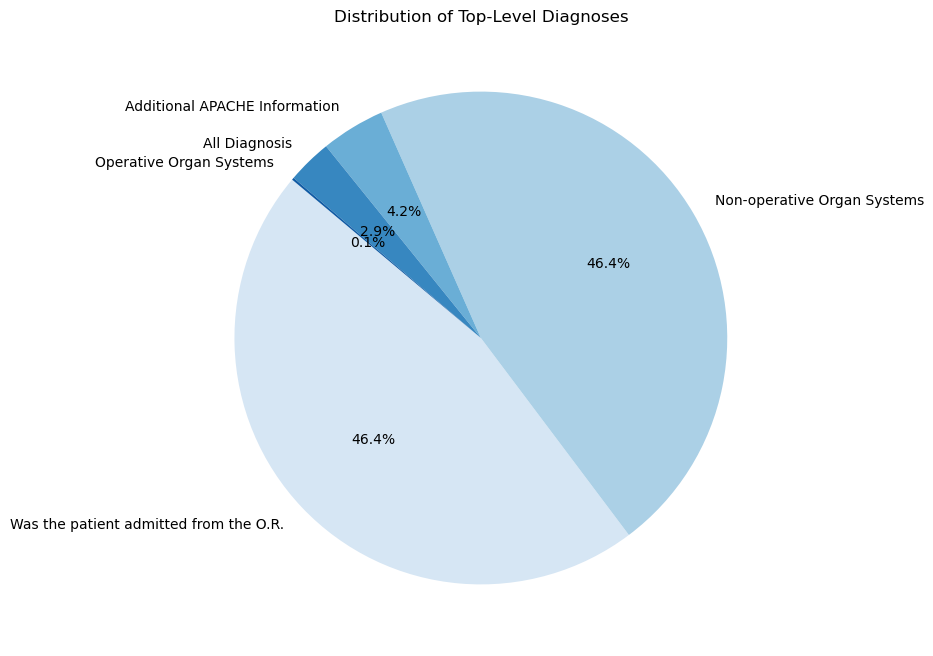

In [16]:
plt.figure(figsize=(8, 8))
plt.pie(df['Annotations'], labels=df['Diagnosis'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(df)))
plt.title('Distribution of Top-Level Diagnoses')
plt.show()

## Diagnosis table

In [76]:
query = query_schema + """
select *
from diagnosis

"""

df_addx = pd.read_sql_query(query, con)
n_dx = df_addx['patientunitstayid'].nunique()
print("There are {} icu patients in the diagnosis record.".format(n_dx))

There are 173109 icu patients in the diagnosis record.


In [78]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select dx.diagnosisid	, dx.activeupondischarge	,dx.diagnosisstring, dx.diagnosispriority,sp.*
from diagnosis dx
join selected_patients sp
  on dx.patientunitstayid = sp.patientunitstayid
 """

df_diagnosis_selected = pd.read_sql_query(query, con)
df_diagnosis_selected.head()

,diagnosisid,activeupondischarge,diagnosisstring,diagnosispriority,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,4222318,False,cardiovascular|chest pain / ASHD|coronary arte...,Other,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
1,3370568,True,cardiovascular|ventricular disorders|cardiomyo...,Other,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
2,4160941,False,pulmonary|disorders of the airways|COPD,Other,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
3,4103261,True,pulmonary|disorders of the airways|COPD,Other,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
4,3545241,True,cardiovascular|ventricular disorders|congestiv...,Other,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired


In [79]:
# df_diagnosis_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_diagnosis.csv')

In [80]:
n_diagnosis_selected= len(df_diagnosis_selected['diagnosisid'])
print("There are {} selected patients in the diagnosis table with total {} records.".format(df_diagnosis_selected['patientunitstayid'].nunique(),n_diagnosis_selected))

There are 96309 selected patients in the diagnosis table with total 1401839 records.


## lab table

In [82]:
query = query_schema + """
select *
from lab
"""

df_lab = pd.read_sql_query(query, con)
n_lab = df_lab['patientunitstayid'].nunique()
print("There are {} icu patients in the lab  record.".format(n_lab))

There are 195730 icu patients in the lab  record.


In [83]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select l.labid, l.labtypeid	,l.labname, l.labresult,l.labmeasurenamesystem, sp.*
from lab l
join selected_patients sp
  on l.patientunitstayid = sp.patientunitstayid
 """

df_lab_selected = pd.read_sql_query(query, con)
df_lab_selected.head()

,labid,labtypeid,labname,labresult,labmeasurenamesystem,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,52307161,3.0,fibrinogen,177.0,mg/dL,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
1,50363251,3.0,PT - INR,2.5,ratio,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
2,49149139,1.0,magnesium,2.0,mg/dL,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
3,50363250,3.0,PT,26.6,sec,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
4,66695374,7.0,pH,7.2,,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired


In [84]:
# df_lab_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_lab.csv')

In [91]:
n_lab_selected= len(df_lab_selected['labid'])
print("There are {} selected patients in the lab table with total {} records.".format(df_lab_selected['patientunitstayid'].nunique(),n_lab_selected))

There are 101285 selected patients in the lab table with total 18262522 records.


## medication cable

In [86]:
query = query_schema + """
select *
from medication
"""

df_med = pd.read_sql_query(query, con)
n_med = df_lab['patientunitstayid'].nunique()
print("There are {} icu patients in the medication record.".format(n_med))

There are 195730 icu patients in the medication record.


In [89]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select med.medicationid,med.drugname, med.dosage, med.frequency, med.prn, med.drugstopoffset,sp.*
from medication med
join selected_patients sp
  on med.patientunitstayid = sp.patientunitstayid
 """

df_med_selected = pd.read_sql_query(query, con)
df_med_selected.head()

,medicationid,drugname,dosage,frequency,prn,drugstopoffset,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,8978843,None,None,BID WC,No,4236,141822,Male,67,Emphysema/bronchitis,Emergency Department,90.7,94.1,Floor,Alive
1,7190905,1 EACH VIAL : CEFTRIAXONE SODIUM 1 G IJ SOLR,1000 MG,Once,No,-18,141822,Male,67,Emphysema/bronchitis,Emergency Department,90.7,94.1,Floor,Alive
2,10405281,DEXTROSE 5 % IV SOLN,100 mL/hr,Continuous PRN,Yes,0,141822,Male,67,Emphysema/bronchitis,Emergency Department,90.7,94.1,Floor,Alive
3,10975801,LORAZEPAM 1 MG PO TABS,2 3,Q1H PRN,Yes,4236,141822,Male,67,Emphysema/bronchitis,Emergency Department,90.7,94.1,Floor,Alive
4,11470013,ONDANSETRON 4 MG PO TBDP,4 3,BID PRN,Yes,4236,141822,Male,67,Emphysema/bronchitis,Emergency Department,90.7,94.1,Floor,Alive


In [90]:
# df_med_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_med.csv')

In [92]:
n_med_selected= len(df_med_selected['medicationid'])
print("There are {} selected patients in the medication table with total {} records.".format(df_med_selected['patientunitstayid'].nunique(),n_med_selected))

There are 84312 selected patients in the medication table with total 3421536 records.


### nursecharting table

In [22]:
query = query_schema + """
select *
from nursecharting
order by nursingchartoffset
"""

df_nursecharting = pd.read_sql_query(query, con)
n_nursecharting = df_nursecharting['patientunitstayid'].nunique()
print("There are {} icu patients in the nursecharting record.".format(n_nursecharting))

: 

In [4]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select nc.nursingchartid, nc.nursingchartcelltypecat, nc.nursingchartcelltypevallabel, nc.nursingchartcelltypevalname, nc.nursingchartvalue, sp.*
from nursecharting nc
join selected_patients sp
  on nc.patientunitstayid = sp.patientunitstayid
 """

df_nchart_selected = pd.read_sql_query(query, con)
df_nchart_selected.head()

: 

## Past History

In [8]:
query = query_schema + """
select *
from pasthistory
order by pasthistoryenteredoffset
"""

df_past = pd.read_sql_query(query, con)
n_past = df_past['patientunitstayid'].nunique()
print("There are {} icu patients in the pasthistary record.".format(n_past))

There are 176258 icu patients in the pasthistary record.


In [9]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select ph.pasthistoryid, ph.pasthistorynotetype,ph.pasthistorypath,ph.pasthistoryvalue,	ph.pasthistoryvaluetext,sp.*
from pasthistory ph
join selected_patients sp
  on ph.patientunitstayid = sp.patientunitstayid
 """

df_past_selected = pd.read_sql_query(query, con)
df_past_selected.head()

,pasthistoryid,pasthistorynotetype,pasthistorypath,pasthistoryvalue,pasthistoryvaluetext,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,1141827,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,AS,AS,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
1,1234145,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,renal failure- not currently dialyzed,renal failure- not currently dialyzed,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
2,1141831,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,CHF - class II,CHF - class II,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
3,1234141,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,Performed,Performed,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
4,1141830,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,hypertension requiring treatment,hypertension requiring treatment,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired


In [10]:
# df_past_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_pasthistory.csv')

In [11]:
n_past_selected= len(df_past_selected['pasthistoryid'])
print("There are {} selected patients in the past history table with total {} records.".format(df_past_selected['patientunitstayid'].nunique(),n_past_selected))

There are 98992 selected patients in the past history table with total 619249 records.


## treatment

In [6]:
query = query_schema + """
select *
from treatment
order by treatmentoffset	
"""

df_treatment = pd.read_sql_query(query, con)
n_tr = df_treatment['patientunitstayid'].nunique()
print("There are {} icu patients in the treatment record.".format(n_tr))

There are 152429 icu patients in the treatment record.


In [12]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select tr.treatmentid, tr.treatmentstring,	tr.activeupondischarge,sp.*
from treatment tr
join selected_patients sp
  on tr.patientunitstayid = sp.patientunitstayid
 """

df_treatment_selected = pd.read_sql_query(query, con)
df_treatment_selected.head()

,treatmentid,treatmentstring,activeupondischarge,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,8399138,cardiovascular|hypertension|angiotensin II rec...,False,242040,Male,78,"CHF, congestive heart failure",Emergency Department,91.71,91.7,Floor,Alive
1,8626134,cardiovascular|myocardial ischemia / infarctio...,False,242040,Male,78,"CHF, congestive heart failure",Emergency Department,91.71,91.7,Floor,Alive
2,8517569,infectious diseases|medications|therapeutic an...,False,242040,Male,78,"CHF, congestive heart failure",Emergency Department,91.71,91.7,Floor,Alive
3,9597686,cardiovascular|non-operative procedures|diagno...,False,242040,Male,78,"CHF, congestive heart failure",Emergency Department,91.71,91.7,Floor,Alive
4,9334096,infectious diseases|medications|therapeutic an...,True,242040,Male,78,"CHF, congestive heart failure",Emergency Department,91.71,91.7,Floor,Alive


In [13]:
# df_treatment_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_treatment.csv')

In [15]:
n_treatment_selected= len(df_treatment_selected['treatmentid'])
print("There are {} selected patients in the treatment table with total {} records.".format(df_past_selected['patientunitstayid'].nunique(),n_treatment_selected))

There are 98992 selected patients in the treatment table with total 1816692 records.


## respiratoryCare

## vitalAperiodic

In [16]:
query = query_schema + """
select *
from vitalAperiodic
order by observationoffset
"""

df_aperiodic = pd.read_sql_query(query, con)
n_vap = df_treatment['patientunitstayid'].nunique()
print("There are {} icu patients in the vitalAperiodic record.".format(n_vap))

There are 152429 icu patients in the vitalAperiodic record.


In [19]:
query = query_schema + """

with selected_patients as (
SELECT DISTINCT patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,	dischargeweight,unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
)
select vap.vitalaperiodicid,vap.observationoffset,vap.noninvasivesystolic,	vap.noninvasivediastolic,	vap.noninvasivemean,	vap.paop,	vap.cardiacoutput,	vap.cardiacinput,	vap.svr,	vap.svri,	vap.pvr,	vap.pvri,sp.*
from vitalaperiodic vap
join selected_patients sp
  on vap.patientunitstayid = sp.patientunitstayid
 """

df_aperiodic_selected = pd.read_sql_query(query, con)
df_aperiodic_selected.head()

,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,...,pvri,patientunitstayid,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargelocation,unitdischargestatus
0,4295739,349,NaN,NaN,79.0,NaN,NaN,NaN,NaN,NaN,...,NaN,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
1,4295737,123,106.0,68.0,81.0,NaN,NaN,NaN,NaN,NaN,...,NaN,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
2,4295741,1398,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,...,NaN,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
3,4295740,441,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,...,NaN,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired
4,4295738,138,111.0,62.0,82.0,NaN,NaN,NaN,NaN,NaN,...,NaN,141168,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,Death,Expired


In [20]:
# df_aperiodic_selected.to_csv('/Users/meisun/Documents/study/thesis/master project/data-preprocessing/selected_patients_aperiodic.csv')

In [21]:
n_aperiodic_selected= len(df_aperiodic_selected['vitalaperiodicid'])
print("There are {} selected patients in the vital aoeriodic table with total {} records.".format(df_past_selected['patientunitstayid'].nunique(),n_aperiodic_selected))

There are 98992 selected patients in the vital aoeriodic table with total 12236146 records.


## vitalPeriodic

In [ ]:
query = query_schema + """
select *
from vitalperiodic
order by observationoffset
"""

df_aperiodic = pd.read_sql_query(query, con)
n_tr = df_treatment['patientunitstayid'].nunique()
print("There are {} icu patients in the vital periodic record.".format(n_tr))